# Section 5

## Preliminaries

### Data Sources
This repository contains two files named `ABELL_3266.fits` and `ABELL_3266_contaminants.fits`, which you will need for the excercises in this section. 

## Assignment

Complete the following problems. Use code cells to develop and run any Python code required and Markdown cells to respond to any auxilliary questions that ask you to interpret your results.

### Exercise 1 (AST4031 & AST5031):

The `ABELL_3266.fits` file in this repository contains the measurements of the velocities and their errors for more than 300 galaxies in the [cluster ABELL-3266](http://www.noao.edu/outreach/press/pr05/images/A3266_1200.jpg). Measuring accurate velocity dispersions for clusters of galaxies is important because it gives an estimate of their dynamical mass (i.e. the total mass of their baryonic and dark matter components). The comparison between the dynamical mass and  the mass locked in stars and gas directly provides a measurement of the amount of dark matter.  

Another example would be the recent paper in _Nature_ by [van Dokkum et al.](https://arxiv.org/abs/1803.10237), which claimed the existence of a galaxy without dark matter, based on the fitted velocity dispersion to a sample of globular clusters in the galaxy.

1. Read in the data that the `ABELL_3266.fits` file contains.
2. By using MLE to fit a Gaussian to the cluster galaxy velocities, obtain the distance of the cluster (i.e. the average velocity) and the cluster's velocity dispersion, accounting for the error in each velocity measurement. 
    * Hint: remember that the convolution of two Gaussians is a Gaussian with variance equal to the sum of the two input variances.
3. So far, we have assumed just one Gaussian is sufficient to describe the velocity distribution of the cluster galaxies i.e. we assumed that all galaxies are cluster members. How would you change the model if I told you that the sample also includes some possible contamination by background and foreground sources? 
    * Hint: the contaminants are uniformly selected to have velocities between 0 and 90,000 km/s. 
4. Formulate the solution of the problem using text and markdown equations. 

In [1]:
import numpy as np
import scipy as sp
import scipy.optimize as spopt
import matplotlib
import matplotlib.pyplot as mplplot

import astropy.io.fits as apfits
import astropy.table as aptable
import astropy.units as apunits
import astropy.cosmology as apcosmo

from IPython.core.display import display

%matplotlib inline

#### Part 1
Reading data from [FITS-format](https://en.wikipedia.org/wiki/FITS) files in Python is straightforward using the `astropy.io.fits` module. The [`open()` function](http://docs.astropy.org/en/stable/io/fits/api/files.html#astropy.io.fits.open) returns an [`HDUList` instance](http://docs.astropy.org/en/stable/io/fits/api/hdulists.html#astropy.io.fits.HDUList). We can use its `info()` method to get an overview of the file contents.

In [2]:
abelDataPath = 'ABELL_3266.fits'
abelDataFits = apfits.open(abelDataPath)
abelDataFits.info()

Filename: ABELL_3266.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      61   ()      
  1  J_AJ_112_36_a3266    1 BinTableHDU     65   317R x 10C   [D, D, J, D, D, E, E, E, J, I]   


We see that the file contains two _extensions_. The zeroth extension is called `PRIMARY` and contains information about the file's prvenance and structure. The data we need are stored as a [Binary Table Header-Data-Unit (`BinTableHDU`)](http://docs.astropy.org/en/stable/io/fits/api/tables.html#astropy.io.fits.BinTableHDU) in the first extension, which is named `J_AJ_112_36_a3266`. 

We can use the [`astropy.table.Table` class](http://docs.astropy.org/en/stable/table/) to read the from the first extension provide a high level interface to the data.

In [3]:
abelDataTable = aptable.Table(abelDataFits['J_AJ_112_36_a3266'].data)

As extra polish we'll use the astropy.units module to associate specific units with each column in our table. We can extract the units for each column from the appropiate `TUNIT*` entry in the _header_ of the first extension. 

Adding units to your data can help to keep track of the quantities you calculate and can also be helpful for plotting axis labels.

In [4]:
for columnCounter, column in enumerate(abelDataTable.columns):
    unitKeyword = 'TUNIT{}'.format(columnCounter+1)
    if unitKeyword in abelDataFits['J_AJ_112_36_a3266'].header:
        columnUnit = apunits.Unit(abelDataFits['J_AJ_112_36_a3266'].header[unitKeyword])
        abelDataTable[column].unit = columnUnit

We can inspect the table column names to determine which contain the velocity data we require

In [5]:
print(*abelDataTable.columns, sep=' : ')

_RAJ2000 : _DEJ2000 : Id : RA1950 : DE1950 : X : Y : R : Vel : e_Vel


The columns we need are `Vel`, containing the measured galaxy (radial line-of-sight) velocities and `e_Vel` containing the associated errors. We can reference those data using the subscript operator (`[]`) on the `Table` instance.

In [6]:
velocities = abelDataTable['Vel']
velocityErrors = abelDataTable['e_Vel']

Now lets make sure that the data look rational by plotting histograms of the velocities and their errors. Note how we use the units we assigned to the column data earlier to compute axis labels. In this case, it's probably an overly complicated way of generating the labels, but it can be a really good cross-check if you're plotting the result of a lengthy calculation and the units aren't what they should be!

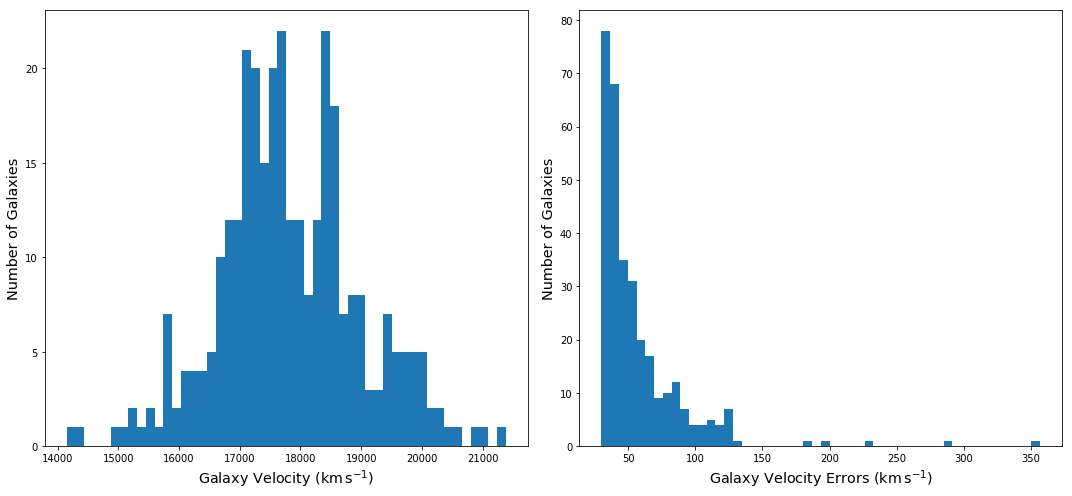

In [7]:
velocityFigure, velocityAxes = mplplot.subplots(figsize=(15,7), nrows=1, ncols=2)

velocityHist = velocityAxes[0].hist(velocities, bins=50)
velocityAxes[0].set_xlabel('Galaxy Velocity ({})'.format(velocities.unit.to_string('latex_inline')),
                           fontsize='x-large')

velocityErrorHist = velocityAxes[1].hist(velocityErrors, bins=50)
velocityAxes[1].set_xlabel('Galaxy Velocity Errors ({})'.format(velocityErrors.unit.to_string('latex_inline')), 
                           fontsize='x-large')

for axisCounter in range(2):
    velocityAxes[axisCounter].set_ylabel('Number of Galaxies', fontsize='x-large')
    
mplplot.tight_layout()

We note that the velocities and their errors seem to have roughly gaussian distributions. Now that the data have been succcessfully loaded, we can use this observation in _Part 2_.

#### Part 2
In order to estimate the required cluster properties using MLE we'll use the following recipe:
1. Define a probability _model_ for the velocity of a single galaxy in the cluster that is parameterised by the cluster properties we are interested in.
2. Construct an expression for the _likelihood_ of observing the ensemble of galaxy velocities that we did, accounting for measurement uncertainties, as instructed.
3. Find values of the interesting cluster properties that maximize the value of our likelihood.

Starting with _Step 1_, we're told to fit a **Gaussian** to the velocities of the cluster galaxies. This seems like a sensible model, now that we've inspected the data. We can extract the cluster velocity ($v$) and velocity dispersion ($\sigma_{v}$) as the Gaussian model mean and standard deviation that maximize the likelihood, given the observed data.

Using this gaussian model, the probability that a particular galaxy $G_{i}$ has a true (or **intrinsic**) velocity $v_{i, \mathrm{int}}$ can be formulated as
$$
P(v_{i, \mathrm{int}}|v, \sigma_{v}) = \frac{1}{\sqrt{2\pi}\sigma_{v}}\exp\left[{-\frac{v_{i, \mathrm{int}}-v}{2\sigma_{v}^{2}}}\right]
$$
where $v$ is the mean velocity of the cluster galaxies and $\sigma_{v}$ is their velocity dispersion. Note that $v$ and $\sigma_{v}$ are the **intrinsic** properties of the galaxy cluster that we are aiming to estimate.

Our data include estimates of the **measurement** errors $\delta_{v, i}$ associated each **observed** galaxy velocity $v_{i, \mathrm{obs}}$. In general, measurement errors mean that $v_{i, \mathrm{obs}}\neq v_{i, \mathrm{int}}$. We can model the probability of **observing** a velocity $v_{i, \mathrm{obs}}$ for $G_{i}$ when its true velocity is $v_{i, \mathrm{int}}$. Referring to the distribution of measurement errors we produced in _Part 1_, a Gaussian model for $v_{i, \mathrm{obs}}$, given $v_{i, \mathrm{int}}$ and $\delta_{v, i}$, seems appropriate.
$$
P(v_{i, \mathrm{int}} | v_{i, \mathrm{obs}}, \delta_{v, i}) = \frac{1}{\sqrt{2\pi}\sigma_{v}}\exp\left[{-\frac{v_{i, \mathrm{int}}-v_{i, \mathrm{obs}}}{2\delta_{v, i}^{2}}}\right]
$$
Now we can write a joint model for **observing** $v_{i, \mathrm{obs}}$ given the **intrinsic**, unknown values of $v$ and $\sigma_{v}$. This joint model is derived by convolving the model for the **intrinsic** cluster properties with that for the individual **measurement** error.
$$
P(v_{i, \mathrm{obs}}|v,\sigma_{v}, \delta_{v, i}) = P(v_{i, \mathrm{int}}|v, \sigma_{v})*P(v_{i, \mathrm{int}}|v_{i, \mathrm{obs}}, \delta_{v, i}) = \displaystyle\int\limits_{-\infty}^{\infty}P(v_{i, \mathrm{int}}|v, \sigma_{v})\cdot P(v_{i, \mathrm{int}}|v_{i, \mathrm{obs}}, \delta_{v, i})~dv_{i, \mathrm{int}}
$$
To get some intuition for why this expression is true consider that $v_{i, \mathrm{obs}}$ will be observed whenever the true velocity is $v$ **and** the measurement error is $v-v_{i, \mathrm{obs}}$. The integrand of the convolution computes the probability of this criterion for a single value of $v_{i, \mathrm{obs}}$. The integration sums the similar probabilities for all possible values of $v_{i, \mathrm{int}}$, yielding the probability of observing $v_{i, \mathrm{obs}}$ for any intrinsic galaxy velocity.

To evaluate the convolution integral, we'll use the hint that we were goven, stating
> the convolution of two Gaussians is a Gaussian with variance equal to the sum of the two input variances.

which leads to our model for observing $v_{i, \mathrm{obs}}$ for galaxy $G_{i}$
\begin{align}
P(v_{i, \mathrm{obs}}|v,\sigma_{v}, \delta_{v, i}) &= \left\{\frac{1}{\sqrt{2\pi}\sigma_{v}}\exp\left[{-\frac{v_{i, \mathrm{int}}-v}{2\sigma_{v}^{2}}}\right]\right\}*\left\{\frac{1}{\sqrt{2\pi}\sigma_{v}}\exp\left[{-\frac{v_{i, \mathrm{obs}}-v_{i, \mathrm{int}}}{2\delta_{v, i}^{2}}}\right]\right\} \\
&= \frac{1}{\sqrt{2\pi}\sigma_{\mathrm{obs,i}}}\exp\left[{-\frac{v_{i, \mathrm{obs}}-v_{i, \mathrm{int}}}{2\sigma_{\mathrm{obs,i}}^{2}}}\right]~:~\sigma_{\mathrm{obs,i}}^{2} = \sigma_{v}^{2}+\delta_{v, i}^{2}
\end{align}

Now we can write down the likelihood of observing an ensemble of $n$ galaxy velocities $\{v_{i, \mathrm{obs}}\}~:~i=1\ldots n$, given their estimated measurement uncertainties $\{\delta_{v,i}\}~:~i=1\ldots n$. This is just the product of the individual galaxy probabilty models.
$$
\mathcal{L}(\{v_{i, \mathrm{obs}}\}|v, \sigma_{v}, \{\delta_{v,i}\}) = \displaystyle\prod\limits_{i=1}^{n} P(v_{i, \mathrm{obs}}|v,\sigma_{v}, \delta_{v, i}) = \displaystyle\prod\limits_{i=1}^{n}\frac{1}{\sqrt{2\pi}\sigma_{\mathrm{obs,i}}}\exp\left[{-\frac{v_{i, \mathrm{obs}}-v_{i, \mathrm{int}}}{2\sigma_{\mathrm{obs,i}}^{2}}}\right]
$$
For [various reasons](https://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution), it is very common to work with the log-likelihood.
$$
\ln\mathcal{L} = \mathrm{constant} + \displaystyle\sum\limits_{i=1}^{n}\left[{-\frac{v_{i, \mathrm{obs}}-v_{i, \mathrm{int}}}{2\sigma_{\mathrm{obs,i}}^{2}}}\right]
$$
To estimate $v$ and $\sigma_{v}$, all that remains is to maximize the non-constant term. Let's write a function that computes non-constant term of the **negative** log-likelihood. We can then find values of $v$ and $\sigma_{v}$ that **minimize** its return value.

In [8]:
def logLikelihood(v, sigmaInt, velocities, velocityErrors):
    sigmaObs = np.sqrt(velocityErrors**2.0 + sigmaInt**2.0)
    likelihood = -0.5*((velocities - v)/(sigmaObs))**2.0 - np.log(sigmaObs)
    return -np.sum(likelihood)

We'll demonstrate two methods to find the values for $v$ and $\sigma_{v}$ that mimimize $-\ln\mathcal{L}$. First, let's try a grid search. We'll define a densely sampled grid of sensible values for $v$ and $\sigma_{v}$, compute $-\ln\mathcal{L}$ for each grid node, and then find the node with the minimum $-\ln\mathcal{L}$ value.

We'll pick our grid values by examining the distribution of galaxy velocities we made in _Part 1_.

In [9]:
# define grid values
vValues = np.linspace(17000, 19000, 70)
sigmaValues = np.linspace(500, 1500, 70)

# compute -log likelihood for each grid node
v, sigma, logLikelihoods = np.array([[vValue, sigmaValue, logLikelihood(np.array(velocities), np.array(velocityErrors), vValue, sigmaValue)] for vValue in vValues for sigmaValue in sigmaValues]).T

Let's plot the results of our grid search. We'll also define a function to compute a Gaussian function that we can use to plot our best fit results.

In [10]:
def gaussian(x, mu, sigma, norm=1.0):
    return norm * np.exp(-0.5*((x-mu)/sigma)**2.0)/(sigma*np.sqrt(2.0*np.pi))

def plotMLE(v, sigma, logLikelihoods, vValues, 
            sigmaValues, maxLikelihoodSolutions, 
            labelPrefixes, gridMarkerKeywords = dict(marker='.', s=5)):
    maxLikelihoodSolutions= np.atleast_2d(maxLikelihoodSolutions)
    labelPrefixes = np.atleast_1d(labelPrefixes)
    
    likelihoodFigure, (likelihoodAxes, gridBestAxes) = mplplot.subplots(figsize=(15,7), 
                                                                        ncols=2, nrows=1, 
                                                                        gridspec_kw=dict(width_ratios=[8,7]))

    ## Plot scatter data and colour bar
    likelihoodScatter = likelihoodAxes.scatter(v, sigma, c=logLikelihoods, **gridMarkerKeywords)
    likelihoodColourBar = mplplot.colorbar(likelihoodScatter, ax=likelihoodAxes)
    likelihoodColourBar.set_label('$-\ln\mathcal{L}$', fontsize='x-large')

    ## Add labelled likelihood contours
    likelihoodGrid = np.reshape(logLikelihoods, (vValues.size, sigmaValues.size), order='F')
    contourLevels = np.percentile(logLikelihoods, q=np.arange(1, 100, 10))
    contourLines = likelihoodAxes.contour(vValues, sigmaValues, likelihoodGrid, colors='k', levels=contourLevels)

    likelihoodAxes.set_ylabel('$\sigma_{\mathrm{int}}$', fontsize='x-large')
    likelihoodAxes.set_xlabel('v', fontsize='x-large')
    likelihoodAxes.set_xlim(np.amin(vValues), np.amax(vValues))
    likelihoodAxes.set_ylim(np.amin(sigmaValues), np.amax(sigmaValues))

    _, binBounds, _ = gridBestAxes.hist(velocities, bins=50, label='ABEL 3266 Velocity Data')
    gridBestAxes.plot(binBounds, gaussian(binBounds, 
                                          *maxLikelihoodSolutions[0], 
                                          norm=velocities.size * (binBounds[1] - binBounds[0])), 
                      lw = 3, label='{} $\mathcal{{L}}_{{\max}}$ Solution'.format(labelPrefixes[0]))
    gridBestAxes.set_xlabel('Galaxy Velocity ({})'.format(velocities.unit.to_string('latex_inline')),
                            fontsize='x-large')
    
    
    for counter, (maxLikelihoodSolution, labelPrefix) in enumerate(zip(maxLikelihoodSolutions, labelPrefixes)):
        likelihoodAxes.scatter(*maxLikelihoodSolution, 
                               marker='*', s=200, c='C{}'.format(counter+3), 
                               label='{} $\mathcal{{L}}_{{\max}}$'.format(labelPrefix))
        gridBestAxes.axvline(x=maxLikelihoodSolution[0], ls='--', c='C{}'.format(counter+3), 
                             label='{} Best fit $v$'.format(labelPrefix))

    likelihoodAxes.legend(loc='best')
    gridBestAxes.legend(loc='upper right')

    mplplot.tight_layout()
    
    return likelihoodFigure, likelihoodAxes, gridBestAxes

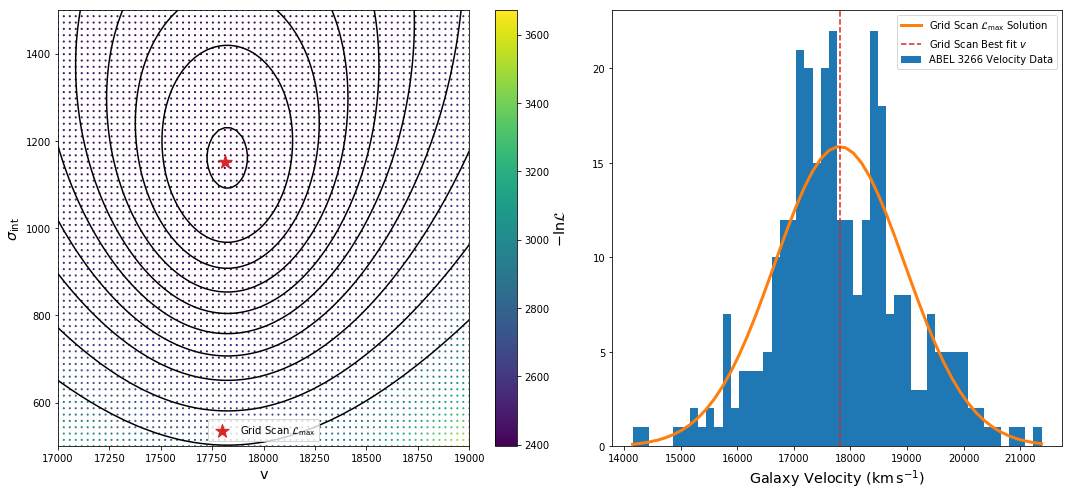

In [11]:
_ = plotMLE(v, sigma, logLikelihoods, vValues, sigmaValues, 
            [v[logLikelihoods.argmin()], sigma[logLikelihoods.argmin()]], 
            'Grid Scan')

The grid search approach seems to have found a solution that corresponds well with the observed data, but the approach has two obvious drawbacks:
1. Only values of $v$ and $\sigma_{v}$ comprising the grid can ever be considered. If the true solution lies between grid nodes, it will never be found.
2. The approach is not efficient, especially in higher dimensional parameter spaces. We computed $-\ln L$ for an unneccessarily large number of grid points.

A better approach is to use a [_gradient descent_ minimization](https://en.wikipedia.org/wiki/Gradient_descent) algorithm. These algorithms efficiently search the parameter space by only examining points that are likely to have lower $-\ln L$ values. They are not restricted to a grid of values and can, in principle, locate the maximum likelihood solution with arbitrary precision.

Many implementations of gradient descent minimizers exist, but we'll use the [`scipy.optimize.minimize` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html). The `minimize` function accepts as arguments an _objective function_ an optional _starting guess_ for the maximum likelihood solution and an optional `tuple` containing arguments to pass to the objective function. The objective function itself must have a specific signature. 
* It **must** accept a list of trial parameter values as it's first argument. 
* It **may** accept additional arguments that it needs to compute its output. These arguments should be passed via the `minimize` function.

We'll define our objective function to accept a list containing trial values for $v$ and $\sigma_{v}$ as its first argument, and arrays containing the observed velocities and estimated measurement errors as the second and third arguments, respectively.

We'll simply unpack the trial values and forward all the arguments to the `logLikelihood` function we already defined.

In [12]:
def spLogLikelihood(vSigmaInt, velocities, velocityErrors):
    return logLikelihood(*vSigmaInt, velocities, velocityErrors)

We're almost ready to run the minimizer. We'll start close to the solution we found using the grid scan. We'll write a function to perturb that solution a small amount so that the minimizer actually has to do something, but more importantly, that it can detect a gradient to descend! If the starting coordinate is too close to the minimum, gradient descent algorithms can actually diverge in an attempt to find a significantly lower solution.

In [13]:
def perturb(x, fraction):
    return np.random.normal(x, np.array(fraction)*x)

# Compute a starting guess by perturbing the grid search minimum 
bestGridPoint = np.array([v[logLikelihoods.argmin()], sigma[logLikelihoods.argmin()]])
perturbedBestGridPoint = perturb(bestGridPoint, [0.5, 0.5])

# Run the gradient descent minimizer
fitResult = spopt.minimize(spLogLikelihood, 
                           x0=perturbedBestGridPoint, 
                           args=(velocities, velocityErrors))

We can verify that the minimizer actually moved closer to the grid search solution from its perturbed start point.

In [14]:
print(
    'Fractional coordinate offsets before fit: {}'.format((perturbedBestGridPoint - fitResult.x)/fitResult.x),
    'Fractional coordinate offsets after fit: {}'.format((bestGridPoint - fitResult.x)/fitResult.x),
    sep='\n'
)

Fractional coordinate offsets before fit: [-0.27235582 -0.30167779]
Fractional coordinate offsets after fit: [-0.00067555 -0.00446643]


Looks like the minimizer did its job. Let's plot the results of the gradient descent mimiizer and compare them with the grid search results.

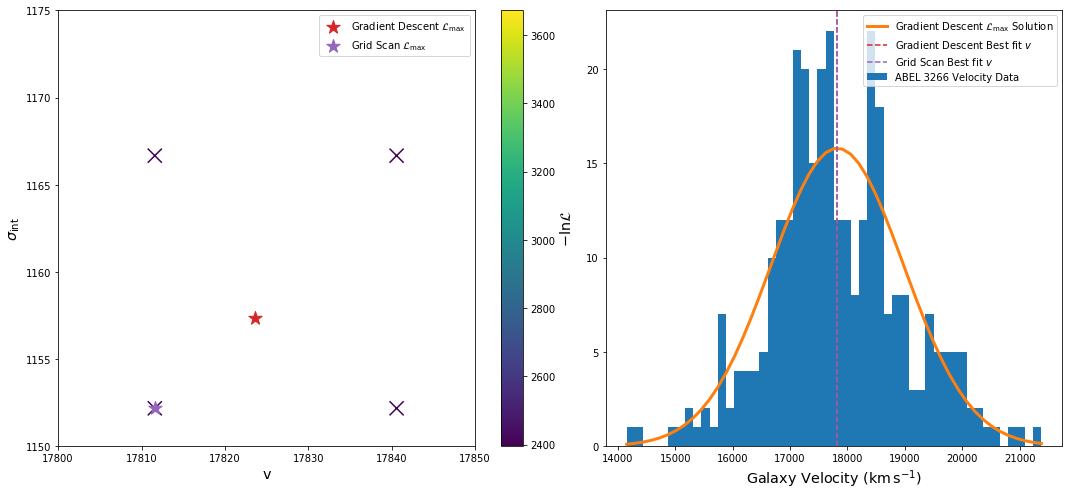

In [15]:
_, twoDimAxes, _ = plotMLE(v, sigma, logLikelihoods, vValues, sigmaValues, 
                           [fitResult.x, bestGridPoint], 
                           ['Gradient Descent', 'Grid Scan'], 
                           gridMarkerKeywords=dict(marker='x', s=200))
twoDimAxes.set_xlim(17800, 17850)
twoDimAxes.set_ylim(1150, 1175)
mplplot.tight_layout()

Finally we can compute the distance ($D$) to the cluster using [Hubble's law](https://en.wikipedia.org/wiki/Hubble%27s_law) (more properly known as the [Hubble–Lemaître law](https://www.iau.org/news/pressreleases/detail/iau1812/?lang)).
\begin{equation}
D=\frac{v}{H_{0}}
\end{equation}
We can use retrieve a value for the Hubble constant $H_{0}$ from the [`astropy.cosmology` module](http://docs.astropy.org/en/stable/cosmology/), assuming a cosmology consistent with ethe Planck 2015 data release. We should also specify the units for our computed velocity. These units will propagate to our computed distance.

In [16]:
abelVelocity = fitResult.x[0]
abelDistance = (abelVelocity*velocities.unit)/apcosmo.Planck15.H0
print('The distance to the ABELL-3266 is {:.4f}'.format(abelDistance))

The distance to the ABELL-3266 is 263.1183 Mpc


Our result is close to the officially accepted distance of [248 Mpc](https://en.wikipedia.org/wiki/Abell_3266).

#### Part 3
Using the information from the hint we can model the contaminants to have a uniform distribution $\mathcal{U}(0,90)$ in the range $0\leq {v_{\mathrm{contam}}}/{1000~\mathrm{km^{-s}}}\leq 90$

$$
\mathcal{U}(0,90)\sim\frac{1}{90\times10^{4}}
$$

By introducing a parameter $\eta$ to describe the fraction of galaxies in our sample that are contaminants, our model for observing $v_{i, \mathrm{obs}}$ for galaxy $G_{i}$ can be straightforwardly updated

\begin{equation}
P(v_{i, \mathrm{obs}}|v,\sigma_{v}, \delta_{v, i}) = \eta\cdot\mathcal{U}(0,90) + (1-\eta)\frac{1}{\sqrt{2\pi}\sigma_{\mathrm{obs,i}}}\exp\left[{-\frac{v_{i, \mathrm{obs}}-v_{i, \mathrm{int}}}{2\sigma_{\mathrm{obs,i}}^{2}}}\right]
\end{equation}

The likelihood for $n$ galaxies is then

$$
\mathcal{L}(\{v_{i, \mathrm{obs}}\}|v, \sigma_{v}, \{\delta_{v,i}\}) = \displaystyle\prod\limits_{i=1}^{n} P(v_{i, \mathrm{obs}}|v,\sigma_{v}, \delta_{v, i}) = \displaystyle\prod\limits_{i=1}^{n}\eta\cdot\mathcal{U}(0,90) + (1-\eta)\frac{1}{\sqrt{2\pi}\sigma_{\mathrm{obs,i}}}\exp\left[{-\frac{v_{i, \mathrm{obs}}-v_{i, \mathrm{int}}}{2\sigma_{\mathrm{obs,i}}^{2}}}\right]
$$


### Exercise 2 (AST5031 Only):

1. Use the `ABELL_3266_contaminants.fits` file in this repository to fit for the cluster velocity dispersion (for simplicity, assume the distance you derived in _Question 2_) and any other parameters you need for the solution you formulated in _Question 4_. 
2. Using MLE, find the best fit velocity dispersion of the cluster in the presence of the outliers.

### Solution
#### Part 1
Let's begin by loading and examining the new data as we did in _Excercise 1_.

In [17]:
abelContamDataPath = 'ABELL_3266_contaminants.fits'
abelContamDataFits = apfits.open(abelContamDataPath)
abelContamDataFits.info()

Filename: ABELL_3266_contaminants.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      60   ()      
  1  J_AJ_112_36_table1    1 BinTableHDU     62   592R x 9C   [D, D, J, D, D, J, I, D, D]   


In [18]:
abelContamDataTable = aptable.Table(abelContamDataFits['J_AJ_112_36_table1'].data)

Again, we'll set the units for each column in our data table.

In [19]:
for columnCounter, column in enumerate(abelContamDataTable.columns):
    unitKeyword = 'TUNIT{}'.format(columnCounter+1)
    if unitKeyword in abelContamDataFits['J_AJ_112_36_table1'].header:
        columnUnit = apunits.Unit(abelContamDataFits['J_AJ_112_36_table1'].header[unitKeyword])
        abelContamDataTable[column].unit = columnUnit

We can define variables to reference the required columns from the data table.

In [20]:
contamVelocities = abelContamDataTable['Vel']
contamVelocityErrors = abelContamDataTable['e_Vel']

As before we can plot the dat aand errors. We note that the velocity data now include several outliers that are not consistent with a Gaussian velocity distribution. The distribution of velocity errors remains approximately Gaussian.

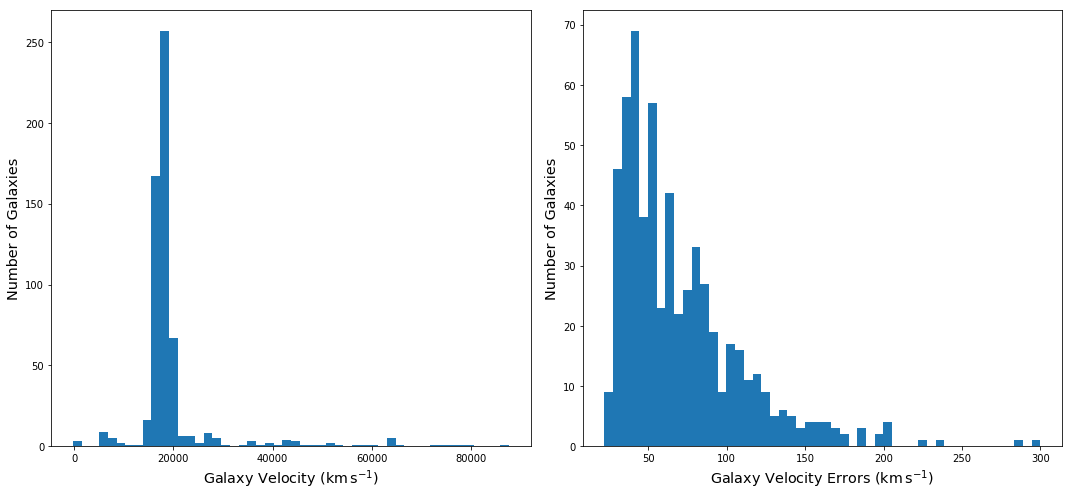

In [21]:
contamVelocityFigure, contamVelocityAxes = mplplot.subplots(figsize=(15,7), nrows=1, ncols=2)

contamVelocityHist = contamVelocityAxes[0].hist(contamVelocities, bins=50)
contamVelocityAxes[0].set_xlabel('Galaxy Velocity ({})'.format(contamVelocities.unit.to_string('latex_inline')),
                           fontsize='x-large')

contamVelocityErrorHist = contamVelocityAxes[1].hist(contamVelocityErrors, bins=50)
contamVelocityAxes[1].set_xlabel('Galaxy Velocity Errors ({})'.format(contamVelocityErrors.unit.to_string('latex_inline')), 
                                 fontsize='x-large')

for axisCounter in range(2):
    contamVelocityAxes[axisCounter].set_ylabel('Number of Galaxies', fontsize='x-large')
    
mplplot.tight_layout()

Now we can define a function to compute the log-likelihood for the model we defined in _Part 4_ of _Excercise 1_. For clarity, we'll use three separate funstions. The first (`uniform`) computes the uniform contaminant model. The second (`contamLikelihood`) computes the full log-likelihood model for the cluster galaxies and contaminants, and the third `spContamLikelihood` wraps `contamLikelihood` with a funstion signature that can be supplied to the `scipy.optimize.minimize` function.

Note that $v$ is no longer a _variable_ parameter of the likelihood, since the question states that we should
> assume the distance you derived in [_Excercise 1_] _Question 2_.

In [22]:
def uniform(x, xMin, xMax):
    inBounds = (x >= xMin) & (x <= xMax)
    return inBounds.astype(float)/(xMax - xMin)

def contamLikelihood(sigmaInt, eta, v, velocities, velocityErrors, contamVelocityRange=[0.0, 9.0e5]):
    sigmaObs = np.sqrt(velocityErrors**2.0 + sigmaInt**2.0)
    signal = (1.0-eta) * gaussian(velocities, v, sigmaObs)
    contam = eta * uniform(velocities, *contamVelocityRange)
    likelihood = np.log(contam + signal)
    return -np.sum(likelihood)

def spContamLikelihood(sigmaIntEta, v, velocities, velocityErrors, contamVelocityRange=[0.0, 9.0e5]):
    return contamLikelihood(*sigmaIntEta, v, velocities, velocityErrors, contamVelocityRange)

Now we can use gradient descent to find the values of $\eta$ and $\sigma_{\mathrm{int}}$ that minimize the log-likelihood. We'll perturb the best solution in the absence of contaminants to obtain an initial guess for $\sigma_{\mathrm{int}}$ and pick a reasonable starting value for $\eta=0.15$.

The `scipy.optimize.minimize` funstion returns a [`scipy.optimize.OptimizeResult` object(https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html#scipy.optimize.OptimizeResult) that encapsulated various information about the fitting process. We can check that the fit succeeded by querying the value of the `OptimizeResult`'s `success` attribute.

In [23]:
contamVelocityRange=[0.0, 9.0e5]
bestV, bestSigma = fitResult.x
_, perturbedSigma = perturb(fitResult.x, [0.5, 0.5])
contamFitResult = spopt.minimize(spContamLikelihood, 
                                 x0=[perturbedSigma, 0.15], 
                                 args=(bestV, contamVelocities, contamVelocityErrors, contamVelocityRange), bounds=[[None, None], [0.1, 0.5]])
print('The likelihood fit {}.'.format('succeeded' if contamFitResult.success else 'failed'))

The likelihood fit succeeded.


We didn't run a grid search in this case so we can define a simpler function to plot the best fit model results.

In [24]:
def plotContamMLE(contamVelocities, contamFitResult, bestV, contamVelocityRange):
    sigmaInt, eta = contamFitResult
    
    modelFigure = mplplot.figure(figsize=(10,6))
    modelAxes = modelFigure.add_subplot(1,1,1)
    _, binBounds, _ = modelAxes.hist(contamVelocities, bins=100, 
                                     label='Contaminated galaxy velocity data')
    norm=contamVelocities.size * (binBounds[1] - binBounds[0])
    
    velocityGrid = np.linspace(*modelAxes.get_xlim(), 500)    
    
    modelAxes.plot(velocityGrid, 
                   norm*(eta*uniform(velocityGrid, *contamVelocityRange) + (1.0-eta)*gaussian(velocityGrid, bestV, sigmaInt)), 
                   label='Best fit model')
    modelAxes.set_yscale('log')
    modelAxes.set_ylabel('Number of Galaxies', fontsize='x-large')
    modelAxes.set_xlabel('v ({})'.format(contamVelocities.unit.to_string('latex')), fontsize='x-large')
    modelAxes.set_ylim(1e-3, modelAxes.get_ylim()[1])
    modelAxes.legend(fontsize='large')
    mplplot.tight_layout()

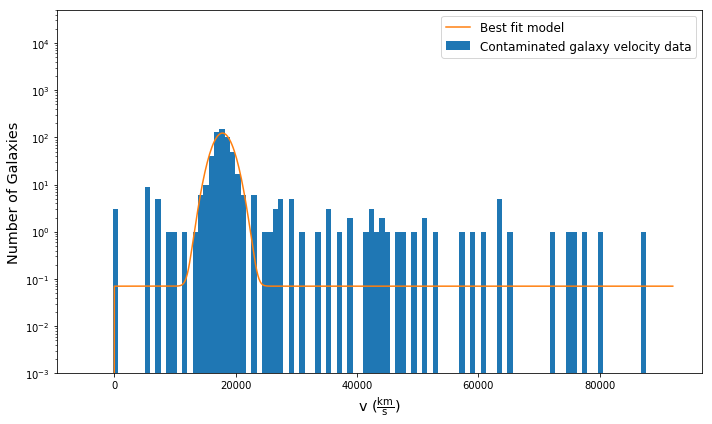

In [25]:
plotContamMLE(contamVelocities, contamFitResult.x, bestV, contamVelocityRange)

Finally, let's extract the best fit velocity dispersion.

In [26]:
print('Best fit velocity dispersion is {:.3f}'.format(contamFitResult.x[0]*contamVelocities.unit))

Best fit velocity dispersion is 1477.427 km / s
